## Installation

In [ ]:
!python -m pip install keras_cv datasets transformers tensorboard tensorflow ipywidgets opencv-python tensorflow-datasets scikit-learn
!git-lfs --version

Login to huggingface if first time

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Show that the GPU is being used

In [1]:
from tensorflow.config.experimental import list_physical_devices
print(list_physical_devices('GPU'))

model_id = "google/vit-base-patch16-224-in21k"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Now create the database, also this is the time to define data augmentation

In [2]:
from transformers import ViTImageProcessor
from datasets import load_dataset
from tensorflow import device
from tensorflow import keras
from tensorflow.keras import layers
from keras_cv.layers import RandAugment
import tensorflow as tf

# Define the model ID and other parameters
num_layers = 2
magnitude = 0.15

# Load the ViTImageProcessor
image_processor = ViTImageProcessor.from_pretrained(model_id)

# Create RandAugment transformation
rand_augment = RandAugment(
    value_range=[-1,1],
    augmentations_per_image=num_layers,
    magnitude=magnitude,
)


def transform(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    inputs["labels"] = batch["label"]
    return inputs

def augment(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    transposed = tf.transpose(inputs["pixel_values"], perm=[0,3,2,1])
    with device('/cpu:0'):
        augmented = rand_augment(transposed)
    inputs["pixel_values"] = tf.transpose(augmented, perm=[0,3,2,1])
    inputs["labels"] = batch["label"]
    return inputs

dataset = load_dataset("streetview_images_cropped", data_dir="./")

eval_size=.15
test_size=.05

dataset = dataset["train"].shuffle().train_test_split(test_size=test_size)
dataset_final_test = dataset['test'].with_transform(transform)

dataset = dataset["train"].train_test_split(test_size=eval_size)
dataset['train'] = dataset['train'].with_transform(augment)
dataset['test'] = dataset['test'].with_transform(transform)
processed_dataset = dataset

Using TensorFlow backend


Resolving data files:   0%|          | 0/42570 [00:00<?, ?it/s]

Specify hyperparameters

In [3]:
from huggingface_hub import HfFolder
import tensorflow as tf

class_labels = processed_dataset['train'].features["label"].names
num_images_train = processed_dataset['train'].num_rows
id2label = {str(i): label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 20
train_batch_size = 32
eval_batch_size = 32
learning_rate = 6e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token()
hub_model_id = f'dl-au-tamas-jedrek/{model_id.split("/")[1]}-street-view'


In [4]:
import json

with open("data/distances.json", "r") as infile:
    distances = json.load(infile)

#make matrix with label2id
import numpy as np
mat_distances = np.zeros((len(label2id), len(label2id)))
for key in distances.keys():
    for key2 in distances[key].keys():
        mat_distances[int(label2id[key])][int(label2id[key2])] = distances[key][key2]
mat_distances

array([[  0.        , 229.02150892, 228.10446099, ..., 157.48504833,
        168.92791079,  68.51475158],
       [229.02150892,   0.        ,   3.83173362, ...,  72.6392153 ,
        257.10553454, 242.08400282],
       [228.10446099,   3.83173362,   0.        , ...,  71.2555174 ,
        258.7988651 , 242.2555515 ],
       ...,
       [157.48504833,  72.6392153 ,  71.2555174 , ...,   0.        ,
        215.85521045, 178.68501914],
       [168.92791079, 257.10553454, 258.7988651 , ..., 215.85521045,
          0.        , 103.66397521],
       [ 68.51475158, 242.08400282, 242.2555515 , ..., 178.68501914,
        103.66397521,   0.        ]])

Get model, specify loss and metrics

In [5]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = num_images_train * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_labels),
    id2label=id2label,
    label2id=label2id,
)

tensor_distances = tf.convert_to_tensor(mat_distances, dtype=tf.float32)
def customLoss(y_true, y_pred):
    y_pred_label = tf.argmax(y_pred, axis=1)
    y_true = tf.reshape(y_true, [-1])
    indices = tf.stack((y_true, y_pred_label), axis=1)
    dist = tf.gather_nd(tensor_distances, indices)
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True) + (dist ** 2)/50
# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = customLoss

def distanceMetric(y_true, y_pred):
    y_pred_label = tf.argmax(y_pred, axis=1)
    y_true = tf.reshape(y_true, [-1])
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.stack((y_true, y_pred_label), axis=1)
    dist = tf.gather_nd(tensor_distances, indices)
    return tf.reduce_mean(dist)

# define metrics 
metrics=[
    distanceMetric,
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

2023-11-19 23:38:38.772489: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-19 23:38:38.772526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 23:38:38.772532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 23:38:38.772824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 23:38:38.772851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kern

In [6]:
model.vit.embeddings.trainable = True
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  99201     
                                                                 
Total params: 85897857 (327.67 MB)
Trainable params: 85897857 (327.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Transform dataset for training

In [7]:
tf_train_dataset = model.prepare_tf_dataset(processed_dataset['train'], batch_size=train_batch_size, shuffle=True)
tf_eval_dataset = model.prepare_tf_dataset(processed_dataset['test'], batch_size=eval_batch_size, shuffle=True)
tf_test_dataset = model.prepare_tf_dataset(dataset_final_test, batch_size=eval_batch_size, shuffle=True)

Run to display train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


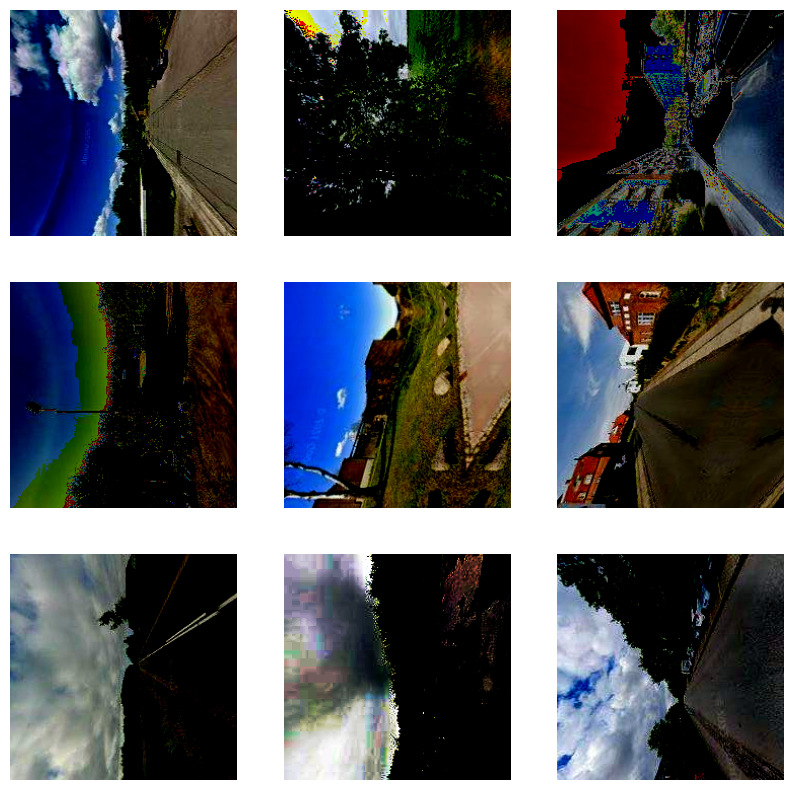

In [8]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(tf_train_dataset))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    transposed = tf.transpose(image)
    plt.imshow(transposed.numpy())
    plt.axis("off")

Push metrics to hub after every epoch

In [9]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks = []
callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir, "logs")))
#callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
callbacks.append(PushToHubCallback(
    output_dir,
    hub_model_id=hub_model_id,
    hub_token=hub_token,
))



/Users/au724747/projects/dl-geolocation-vit/vit-base-patch16-224-in21k is already a clone of https://huggingface.co/dl-au-tamas-jedrek/vit-base-patch16-224-in21k-street-view. Make sure you pull the latest changes with `repo.git_pull()`.


Train model

In [10]:
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_info()
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
    verbose=1
)

Epoch 1/20


2023-11-19 23:38:49.919215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1074/1074 [==============================] - ETA: 0s - loss: 4.5269 - distanceMetric: 112.3383 - accuracy: 0.0599 - top-3-accuracy: 0.1302

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3103s 3s/step - loss: 4.5269 - distanceMetric: 112.3383 - accuracy: 0.0599 - top-3-accuracy: 0.1302 - val_loss: 4.1928 - val_distanceMetric: 100.0691 - val_accuracy: 0.1085 - val_top-3-accuracy: 0.2159
Epoch 2/20
1074/1074 [==============================] - ETA: 0s - loss: 3.9993 - distanceMetric: 94.2949 - accuracy: 0.1305 - top-3-accuracy: 0.2554

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3065s 3s/step - loss: 3.9993 - distanceMetric: 94.2949 - accuracy: 0.1305 - top-3-accuracy: 0.2554 - val_loss: 3.7977 - val_distanceMetric: 90.1232 - val_accuracy: 0.1564 - val_top-3-accuracy: 0.2898
Epoch 3/20
1074/1074 [==============================] - ETA: 0s - loss: 3.5587 - distanceMetric: 82.4324 - accuracy: 0.1970 - top-3-accuracy: 0.3571

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2978s 3s/step - loss: 3.5587 - distanceMetric: 82.4324 - accuracy: 0.1970 - top-3-accuracy: 0.3571 - val_loss: 3.4996 - val_distanceMetric: 78.6708 - val_accuracy: 0.2088 - val_top-3-accuracy: 0.3618
Epoch 4/20
1074/1074 [==============================] - ETA: 0s - loss: 3.1366 - distanceMetric: 72.6107 - accuracy: 0.2719 - top-3-accuracy: 0.4511

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2978s 3s/step - loss: 3.1366 - distanceMetric: 72.6107 - accuracy: 0.2719 - top-3-accuracy: 0.4511 - val_loss: 3.2514 - val_distanceMetric: 78.9631 - val_accuracy: 0.2409 - val_top-3-accuracy: 0.4137
Epoch 5/20
1074/1074 [==============================] - ETA: 0s - loss: 2.7103 - distanceMetric: 61.4000 - accuracy: 0.3568 - top-3-accuracy: 0.5529

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2977s 3s/step - loss: 2.7103 - distanceMetric: 61.4000 - accuracy: 0.3568 - top-3-accuracy: 0.5529 - val_loss: 3.0831 - val_distanceMetric: 70.2929 - val_accuracy: 0.2763 - val_top-3-accuracy: 0.4539
Epoch 6/20
1074/1074 [==============================] - ETA: 0s - loss: 2.2918 - distanceMetric: 50.8318 - accuracy: 0.4465 - top-3-accuracy: 0.6490

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2980s 3s/step - loss: 2.2918 - distanceMetric: 50.8318 - accuracy: 0.4465 - top-3-accuracy: 0.6490 - val_loss: 2.9808 - val_distanceMetric: 69.5126 - val_accuracy: 0.2951 - val_top-3-accuracy: 0.4752
Epoch 7/20
1074/1074 [==============================] - ETA: 0s - loss: 1.8789 - distanceMetric: 40.8479 - accuracy: 0.5409 - top-3-accuracy: 0.7342

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2977s 3s/step - loss: 1.8789 - distanceMetric: 40.8479 - accuracy: 0.5409 - top-3-accuracy: 0.7342 - val_loss: 2.9431 - val_distanceMetric: 66.2979 - val_accuracy: 0.3191 - val_top-3-accuracy: 0.4979
Epoch 8/20
1074/1074 [==============================] - ETA: 0s - loss: 1.4891 - distanceMetric: 31.6089 - accuracy: 0.6344 - top-3-accuracy: 0.8090

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2979s 3s/step - loss: 1.4891 - distanceMetric: 31.6089 - accuracy: 0.6344 - top-3-accuracy: 0.8090 - val_loss: 2.9450 - val_distanceMetric: 65.7985 - val_accuracy: 0.3251 - val_top-3-accuracy: 0.5131
Epoch 9/20
1074/1074 [==============================] - ETA: 0s - loss: 1.1515 - distanceMetric: 24.2657 - accuracy: 0.7180 - top-3-accuracy: 0.8673

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2980s 3s/step - loss: 1.1515 - distanceMetric: 24.2657 - accuracy: 0.7180 - top-3-accuracy: 0.8673 - val_loss: 2.9861 - val_distanceMetric: 63.5139 - val_accuracy: 0.3274 - val_top-3-accuracy: 0.5094
Epoch 10/20
1074/1074 [==============================] - ETA: 0s - loss: 0.9088 - distanceMetric: 19.0660 - accuracy: 0.7803 - top-3-accuracy: 0.9024

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2979s 3s/step - loss: 0.9088 - distanceMetric: 19.0660 - accuracy: 0.7803 - top-3-accuracy: 0.9024 - val_loss: 3.0831 - val_distanceMetric: 65.0193 - val_accuracy: 0.3318 - val_top-3-accuracy: 0.5107
Epoch 11/20
1074/1074 [==============================] - ETA: 0s - loss: 0.7098 - distanceMetric: 15.4008 - accuracy: 0.8271 - top-3-accuracy: 0.9306

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2977s 3s/step - loss: 0.7098 - distanceMetric: 15.4008 - accuracy: 0.8271 - top-3-accuracy: 0.9306 - val_loss: 3.1146 - val_distanceMetric: 63.7837 - val_accuracy: 0.3403 - val_top-3-accuracy: 0.5167
Epoch 12/20
1074/1074 [==============================] - ETA: 0s - loss: 0.5640 - distanceMetric: 12.2652 - accuracy: 0.8616 - top-3-accuracy: 0.9475

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2980s 3s/step - loss: 0.5640 - distanceMetric: 12.2652 - accuracy: 0.8616 - top-3-accuracy: 0.9475 - val_loss: 3.2037 - val_distanceMetric: 63.5982 - val_accuracy: 0.3419 - val_top-3-accuracy: 0.5190
Epoch 13/20
1074/1074 [==============================] - ETA: 0s - loss: 0.4870 - distanceMetric: 11.0982 - accuracy: 0.8795 - top-3-accuracy: 0.9546

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3045s 3s/step - loss: 0.4870 - distanceMetric: 11.0982 - accuracy: 0.8795 - top-3-accuracy: 0.9546 - val_loss: 3.2612 - val_distanceMetric: 64.1155 - val_accuracy: 0.3401 - val_top-3-accuracy: 0.5142
Epoch 14/20
1074/1074 [==============================] - ETA: 0s - loss: 0.4317 - distanceMetric: 9.6983 - accuracy: 0.8932 - top-3-accuracy: 0.9600

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3102s 3s/step - loss: 0.4317 - distanceMetric: 9.6983 - accuracy: 0.8932 - top-3-accuracy: 0.9600 - val_loss: 3.3567 - val_distanceMetric: 65.4854 - val_accuracy: 0.3323 - val_top-3-accuracy: 0.5089
Epoch 15/20
1074/1074 [==============================] - ETA: 0s - loss: 0.3833 - distanceMetric: 9.1444 - accuracy: 0.9025 - top-3-accuracy: 0.9646

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3015s 3s/step - loss: 0.3833 - distanceMetric: 9.1444 - accuracy: 0.9025 - top-3-accuracy: 0.9646 - val_loss: 3.4377 - val_distanceMetric: 67.0008 - val_accuracy: 0.3343 - val_top-3-accuracy: 0.5122
Epoch 16/20
1074/1074 [==============================] - ETA: 0s - loss: 0.3454 - distanceMetric: 8.2372 - accuracy: 0.9129 - top-3-accuracy: 0.9686

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2998s 3s/step - loss: 0.3454 - distanceMetric: 8.2372 - accuracy: 0.9129 - top-3-accuracy: 0.9686 - val_loss: 3.5423 - val_distanceMetric: 65.3304 - val_accuracy: 0.3289 - val_top-3-accuracy: 0.4995
Epoch 17/20
1074/1074 [==============================] - ETA: 0s - loss: 0.3216 - distanceMetric: 7.8176 - accuracy: 0.9164 - top-3-accuracy: 0.9718

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2996s 3s/step - loss: 0.3216 - distanceMetric: 7.8176 - accuracy: 0.9164 - top-3-accuracy: 0.9718 - val_loss: 3.4719 - val_distanceMetric: 66.3016 - val_accuracy: 0.3451 - val_top-3-accuracy: 0.5162
Epoch 18/20
1074/1074 [==============================] - ETA: 0s - loss: 0.2975 - distanceMetric: 7.2330 - accuracy: 0.9226 - top-3-accuracy: 0.9731

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3001s 3s/step - loss: 0.2975 - distanceMetric: 7.2330 - accuracy: 0.9226 - top-3-accuracy: 0.9731 - val_loss: 3.5020 - val_distanceMetric: 65.2554 - val_accuracy: 0.3399 - val_top-3-accuracy: 0.5160
Epoch 19/20
1074/1074 [==============================] - ETA: 0s - loss: 0.2838 - distanceMetric: 7.0118 - accuracy: 0.9257 - top-3-accuracy: 0.9758

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3044s 3s/step - loss: 0.2838 - distanceMetric: 7.0118 - accuracy: 0.9257 - top-3-accuracy: 0.9758 - val_loss: 3.5711 - val_distanceMetric: 63.7320 - val_accuracy: 0.3487 - val_top-3-accuracy: 0.5157
Epoch 20/20
1074/1074 [==============================] - ETA: 0s - loss: 0.2597 - distanceMetric: 6.4285 - accuracy: 0.9314 - top-3-accuracy: 0.9765

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3027s 3s/step - loss: 0.2597 - distanceMetric: 6.4285 - accuracy: 0.9314 - top-3-accuracy: 0.9765 - val_loss: 3.5853 - val_distanceMetric: 64.4144 - val_accuracy: 0.3500 - val_top-3-accuracy: 0.5217


## Attention Heatmap

### Prepare and image

In [ ]:
one_image = tf_test_dataset.take(1)

# Now, you can iterate through the one_image dataset to get the individual image and label
for image_batch, label_batch in one_image:
    # Assuming image_batch has shape (32, 3, 224, 224) and label_batch has shape (32,)
    # You can select one image from the batch, for example, the first image:
    single_image = image_batch
    single_label = label_batch[0]
    print(f"Loaded {single_label}")

result = model(single_image, output_attentions=True)
attention_score = result.attentions


preprocessed_image = tf.transpose(single_image[0])
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0)
preprocessed_img_orig = tf.image.flip_left_right(preprocessed_img_orig)
preprocessed_img_orig = tf.image.rot90(preprocessed_img_orig).numpy()

### Display attention heatmap

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def attention_heatmap(attention_scores, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1
    batch_size = 32
    num_heads = 12
    patch_size = 16

    # Process the attention maps for overlay.
    w_featmap = 224 // patch_size
    h_featmap = 224 // patch_size

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 1, num_tokens:].numpy().reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(224,224)
    ) 
    return attentions

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score[0], preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig)
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.5)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(preprocessed_img_orig)
plt.axis("off")

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

predictions = np.array([])
true_labels = np.array([])

for x, y in tf_test_dataset:
    y_prob = model.predict(x)
    # Apply softmax to obtain probabilities
    probabilities = tf.nn.softmax(y_prob.logits, axis=-1).numpy()
    # Get the predicted labels (class with the highest probability)
    y_pred = tf.argmax(probabilities, axis=-1).numpy()

    predictions = np.concatenate([predictions, y_pred])
    print(y_pred)
    print(y.numpy())
    true_labels = np.concatenate([true_labels, y.numpy()])

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()